# Qubit-Resonator Design

Senario: We want to design a resonator coupled to a transmon. What kind of parameters need to be determined before drawing a mask

For the resonator, determine:
- $\omega_r$ : resonant (angular) frequency 
- $\kappa$ : linewidth of the resonance

Then calculate:
- $l$ : length of the resonator
- $C_c$ : coupling capacitance to the feedline.

For the transmon, determine:
- $f_{01}$ : qubit frequency
- $\alpha$ : anharmonicity
- $g$ : coupling strength between the resonator and transmon. 
- $\chi$: $\chi$ shift

Then calculate:
- $E_j$ : Josepthon energy
- $E_c$ : Charging energy
- $C_g$ : coupling capacitance between qubit island to the resonator
- $C_s$ : shunt capacitance across Josephson junction

Note on choosing parameters. $g$, $\chi$, $\kappa$, $\Delta$, $\omega_r$.

- For charge-sensitive qubit, small $E_j/E_c$. Charge dispersion and qubit frequency determine $E_j$ and $E_c$ uniquely.
- For a normal transmon, $E_j/E_c = 50-60$.There is a room for anharmoncity. It affects the tyep of gate operation, gate speed, etc.
- Depending on weak-dispersive ($\kappa \gg 2\chi$) vs strong-dispersive ($\kappa\ll2\chi$) vs intermediate regime (for high-fidelity measurement, $\kappa=2\chi$), $\chi$ and $\kappa$ are determined. $\chi=\left(\frac{g^2}{\Delta}\right)\cdot\left(\frac{\alpha}{\Delta+\alpha}\right)$.
- Put relation Qc vs Cc for capacitive and inductive coupling


## Lumped Element Approximation (LEA)
Ref: Madison Github, Simulation-and-design 

Consider a quarter-wave-resonator coupled inductively or capacitively to a feedline, qubit, etc. The undressed (i.e. no loading) resonator is pulled to lower frequency due to the extra capacitance or inductance via such couplings. We want to estimate the length of the resonator for a given undressed or dressed frequency, using lumped element approximation (LEA) where the resonator is approximated by two lumped elements of inductor ($L_{\rm LEA}$) and capacitor ($C_{\rm LEA}$).

Parameter defination:

$\omega_{\rm ud}$: undressed resonator frequency

$\omega_{\rm d}$: dressed resonator frequency

\begin{eqnarray}
\omega_{\rm d} &=& \frac{1}{\sqrt{L_{\rm tot}C_{\rm tot}}} \\
C_{\rm tot} &=& C_{\rm LEA} + C_{\rm parasitic} \\
L_{\rm tot} &=& L_{\rm LEA} + L_{\rm parasitic} \\
C_{\rm LEA} &=& \left( \frac{\pi}{4 Z_0}\right)  \frac{1}{\omega_{\rm ud}}\\
L_{\rm LEA} &=&\left(\frac{4Z_0}{\pi}\right) \frac{1}{\omega_{\rm ud}}
\end{eqnarray}

To rewrite,
\begin{eqnarray}
\frac{1}{\omega_{\rm d}^2} &=& L_{\rm tot}C_{\rm tot} \\   
x^2 &+&\left( \frac{1}{\omega_{C_p}} +\frac{1}{\omega_{L_p}}\right)x + \frac{1}{\omega_{L_pC_p}^2}-\frac{1}{\omega_{\rm d}^2} =0\\
 \end{eqnarray}
, where
\begin{eqnarray}
x&=&\frac{1}{\omega_{\rm ud}}\\
\omega_{C_p}&=&\frac{\pi}{4Z_0 C_{\rm paracitic}} \\
\omega_{L_p}&=&\frac{4Z_0}{\pi L_{\rm paracitic}} \\
\omega_{L_pC_p}&=&\frac{1}{\sqrt{L_{\rm paracitic}C_{\rm paracitic}}} \\
\end{eqnarray}

Solving for $\omega_{\rm ud}$,

\begin{eqnarray}
x=\frac{1}{\omega_{\rm ud}} &=& \frac{1}{2}\left( -\left(\frac{1}{\omega_{L_p}}+\frac{1}{\omega_{C_p}}\right)+ \sqrt{\left(\frac{1}{\omega_{L_p}}+\frac{1}{\omega_{C_p}}\right)^2 + 4\left(\frac{1}{\omega_{\rm d}^2}-\frac{1}{\omega_{L_pC_p}^2}\right)}\right )
\end{eqnarray}

The length of quarter-wave-resonator $l$ is
\begin{equation}
l=\frac{\lambda}{4} = \frac{\pi v_{ph}}{2\omega_{ud}}.
\end{equation}

## Inductive coupling vs Qc
\begin{eqnarray}
Q_c &=& \frac{2 Z_0 L_{LEA}}{\omega_{\rm ud} M^2} \\
&=&\frac{8Z_0^2}{\pi\omega_{\rm ud}^2 M^2} \\
&=&\frac{2}{\pi}\left(\frac{2Z_0}{\omega_{\rm ud} M}\right)^2
\end{eqnarray}

# Design example for quart-wave resonator + transmon

In [2]:
%matplotlib notebook
from math import pi
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import h, hbar, e, epsilon_0, c, mu_0
import pandas as pd

from transmonCPW import CPW, QuarterWaveResonator, Transmon

In [5]:
# readout cavity - quarterwave resonator
res = QuarterWaveResonator(w=20
                           , s=10
                           , h=500
                           , t=0.1
                           , epsilon_r=11.6                                                     
                           , w_r=6.6e9 * (2*pi)
                           , kappa=0.66e6 * (2*pi)                           
                          )

# Transmon
q = Transmon.in_GHz(Ej=15, Ec=0.286)
q.C_g = 3e-15

In [6]:
res.Z0
res.resonator_length

0.004977268865722193

In [5]:
#624.50000 find Ej and Ec, given f01 and anharmonicity

# sol = q.find_Ej_Ec(4e9, -0.45e9)
# (q.Ej, q.Ec) = sol
# print(q.anharmonicity/1e6)
# print(q.f01/1e9)
# print(q.charge_dispersion/1e6)

In [12]:
# show all parameters

d = np.array([[q.Ej/1e9/h, q.Ec/1e6/h, q.Ej_to_Ec_ratio, q.charge_dispersion/1e3
               , q.f01/1e9, q.anharmonicity/1e6, q.g01(res)/2/pi/1e6
               , q.Chi01(res)/2/pi/1e6, q.Lj/1e-9, q.Ic/1e-9, q.total_cap/1e-15, (q.total_cap-q.C_g)/1e-15
               , q.C_g/1e-15, res.w_r/2/pi/1e9, res.resonator_length*1e3
               , res.Qc, res.kappa/2/pi/1e6, res.Z0, res.epsilon_eff, res.Mc /1e-12
               ,res.C_l/1e-12,res.Lm_l/1e-9, res.Lk_l/1e-9
              ]])
columns = ['Ej (GHz)', 'Ec (MHz)', 'Ej/Ec', 'charge disp. (kHz)', 'f01 (GHz)', 'anharm. (MHz)'
           , '$g/2\pi$ (MHz)', '$\chi/2\pi$ (MHz)', 'Lj (nH)','Ic (nA)','C_sigma (fF)'
           ,'C_sh (fF)','C_g (fF)','fr (GHz)','Res. Length (mm)','Qc'
           , '$\kappa/2\pi$ (MHz)', 'Z0 $(\Omega)$', '$\epsilon_{\rm re}$','Mc (pH)'
           ,'C_l (pH)', 'Lm_l (nH)','Lk_l (nH)' ]

df = pd.DataFrame(d.transpose(), index=columns, columns=['Values'])
df

,Values
Ej (GHz),15.000000
Ec (MHz),286.000000
Ej/Ec,52.447552
charge disp. (kHz),7.527600
f01 (GHz),5.556169
anharm. (MHz),-327.144891
$g/2\pi$ (MHz),55.030849
$\chi/2\pi$ (MHz),-0.351930
Lj (nH),10.897434
Ic (nA),30.200318


In [37]:
1/(res.kappa*(q.g01(res)/(q.f01*2*np.pi-res.w_r))**2)/1e-6

169.65506338120574

In [6]:
q.g01_Madison(res)

320896483.29664505

# Parameter investigation

## C_l vs thickness of substrate

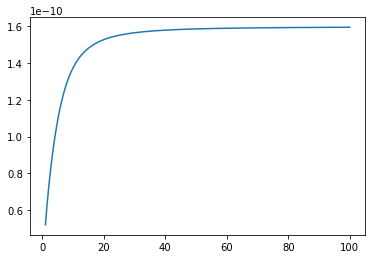

In [11]:
# plot C_l vs thickness of substrate

h_list = np.linspace(1, 100, 1000)
C_l_list = []
for h in h_list:
    res.h = h
    C_l_list.append(res.C_l)
    
plt.plot(h_list, C_l_list)


## Asymmetric transmon

In [51]:
Ej_ratio = 2
d = (Ej_ratio - 1)/(Ej_ratio + 1)
Ej_USS = 28
Ec = 0.33


Ej_LSS = Ej_USS*d

q1 = Transmon.in_GHz(Ej_USS, Ec)
USS = q1.f01
q1 = Transmon.in_GHz(Ej_LSS, Ec)
LSS = q1.f01
print(f'USS = {USS/1e9}, LSS={LSS/1e9}')

USS = 8.25352013910591, LSS=4.60676711805653


<IPython.core.display.Javascript object>


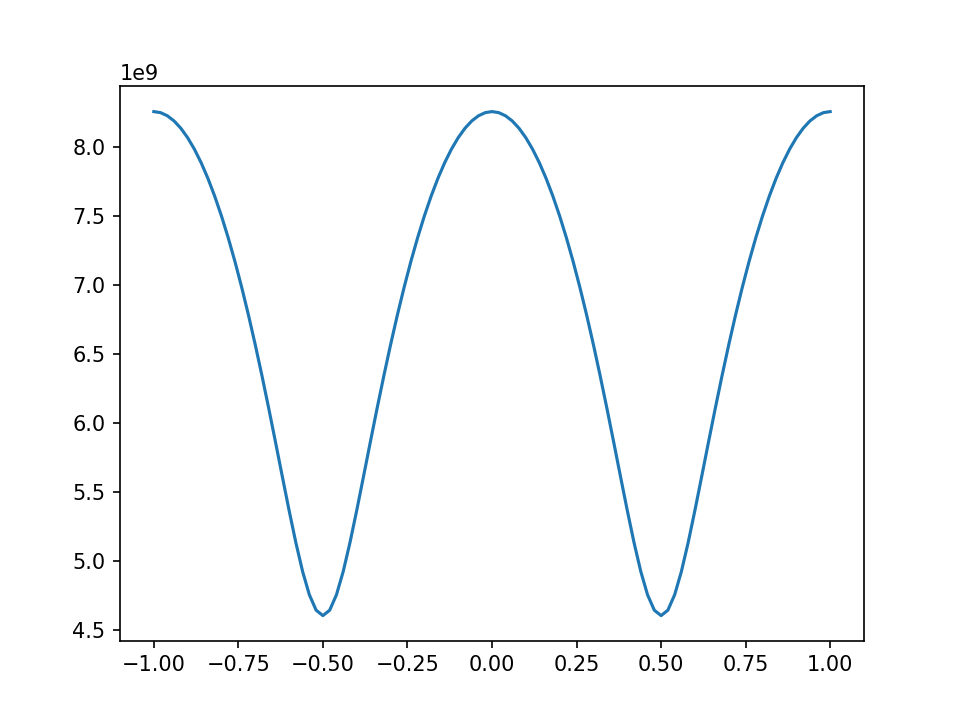

In [50]:
q1.C_g = 3e-15
Ej_AT = lambda Ej_USS, d, f: Ej_USS*np.cos(np.pi*f)*np.sqrt(1+d**2*np.tan(np.pi*f)**2) 
f_list = np.linspace(-1,1, 51)
Ej_list = Ej_AT(Ej_USS, d, f_list)
f01_list = []
for Ej in Ej_list:
    q1.Ej = Ej*h*1e9
    f01_list.append(q1.f01)
plt.plot(f_list, f01_list)

In [56]:
plt.show()

## Anharmonicity vs Ej/Ec for different N

In [3]:
# conclusion: Use N>8. I use N=10.

Ej = 10
Ec = np.linspace(0.2,5, 100) 
Ec = np.logspace(-1, 1.5, 50)

Ns = [4, 6, 8, 10, 12]
qs = [Transmon.in_GHz(Ej=Ej,Ec=0, N=n) for n in Ns]
anharms = []

for q in qs:
    anh = np.array([])
    for E in Ec:
        q.Ec = E *1e9*h
        anh = np.append(anh, q.anharmonicity)
    anharms.append(anh)

# anharms

<IPython.core.display.Javascript object>


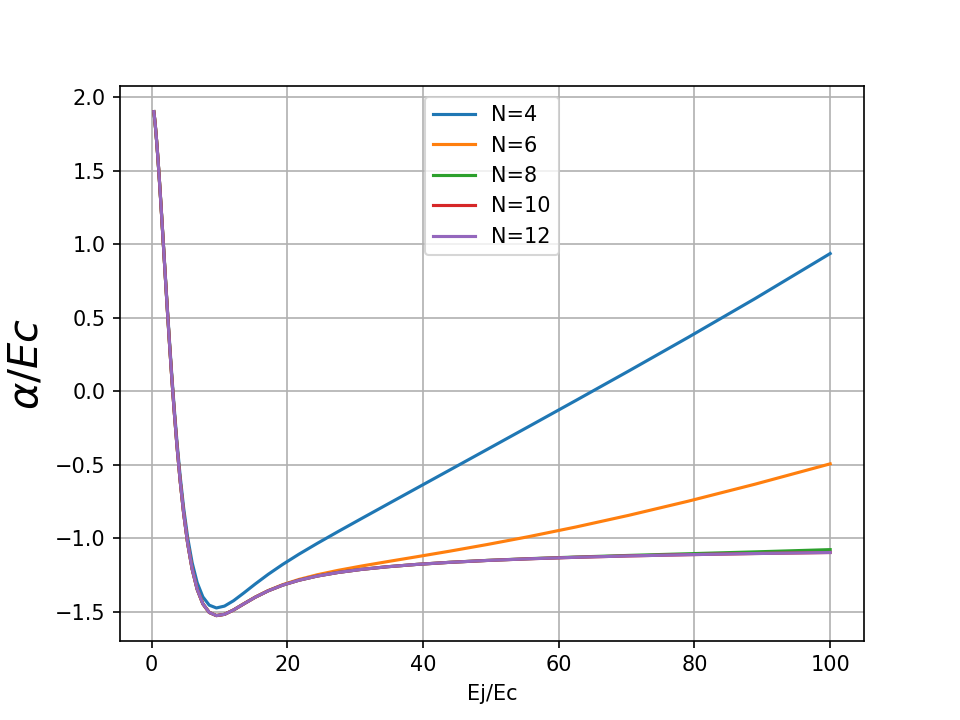

In [4]:
# import plotly
# import plotly.graph_objs as go
# from plotly.offline import iplot
# plotly.offline.init_notebook_mode(connected=True)

for anh in anharms:        
    plt.plot(Ej/Ec, anh/(Ec*1e9), '-')

plt.tick_params
plt.xlabel('Ej/Ec')
plt.ylabel(r'$\alpha/Ec$', fontsize=20)
plt.grid()
plt.legend([f'N={n}' for n in Ns])

# # iplot
# data = []
# for anh in anharms:
#     data.append(go.Scatter(x=Ej/Ec, y=anh/(Ec*1e9)))
    
# iplot({
#     "data": data,
#     "layout": go.Layout(title="Anharmoniciity vs Ej/Ec")
    
# })

In [50]:
from scipy.special import ellipk
k=10/(10+12)
k_p = np.sqrt(1-k**2)

k_sq = k**2
k_p_sq=k_p**2

print(ellipk(k_sq)/ellipk(k_p_sq))
print(np.pi/np.log(2*(1+np.sqrt(k_p))/(1-np.sqrt(k_p))))

0.7415902026988156
0.7415901873874097
